In [1]:
import deepwave
import torch
import scipy.io as spio
import numpy as np
import matplotlib.pyplot as plt

/home/wuyuping/.conda/envs/pytorch_env/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/wuyuping/.conda/envs/pytorch_env/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/wuyuping/.conda/envs/pytorch_env/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/wuyuping/.conda/envs/pytorch_env/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
%matplotlib inline

In [3]:
# Set default dtype to float32
torch.set_default_dtype(torch.float32)

# PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

In [4]:
device = torch.device('cuda:0')

In [5]:
velocity_filename = '../data/Overthrust3D.mat'
save_path = '../data/'

In [6]:
data = spio.loadmat(velocity_filename)

velocity = torch.from_numpy(data[str('velocity')])

print(velocity.shape)

torch.Size([401, 401, 93])


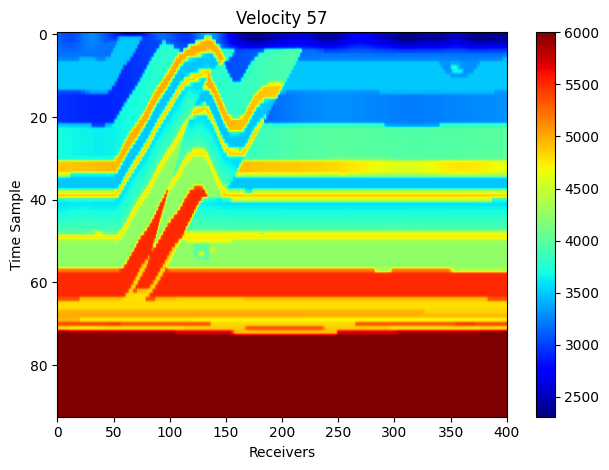

In [9]:
shot_index = 50
vmin, vmax = torch.quantile(velocity[:,:,shot_index],
                            torch.tensor([0.01, 0.99]))
plt.imshow(velocity[1,:,:].T.cpu(), aspect='auto',
             cmap='jet')
plt.xlabel("Receivers")
plt.ylabel("Time Sample")
plt.title("Velocity 57")
plt.colorbar()

plt.tight_layout()
# plt.savefig(result_path+'observed data.jpg')

spio.savemat(save_path + 'Overthrust3D_velocity.mat',{'velocity':velocity.cpu().data.numpy()})

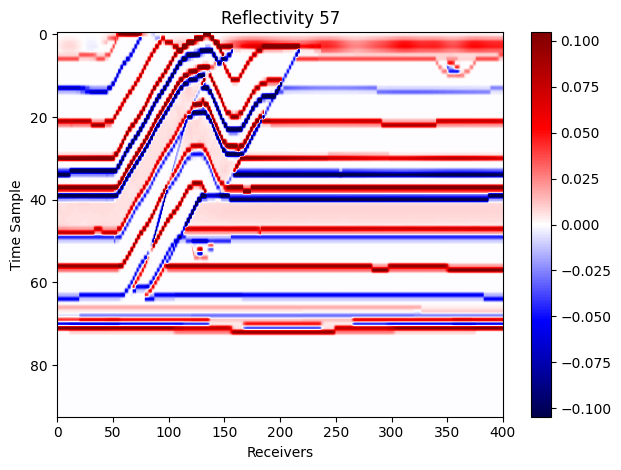

In [10]:
reflectivity = torch.zeros_like(velocity)

reflectivity[:,:,0:92] = (velocity[:,:,1:93] - velocity[:,:,0:92]) / (velocity[:,:,1:93] + velocity[:,:,0:92])

shot_index = 50
vmin, vmax = torch.quantile(reflectivity[:,:,shot_index],
                            torch.tensor([0.01, 0.99]))
plt.imshow(reflectivity[1,:,:].T.cpu(), aspect='auto',
             cmap=plt.cm.seismic, vmin=-vmax, vmax=vmax)
plt.xlabel("Receivers")
plt.ylabel("Time Sample")
plt.title("Reflectivity 57")
plt.colorbar()

plt.tight_layout()
# plt.savefig(result_path+'observed data.jpg')

spio.savemat(save_path + 'Overthrust3D_reflectivity.mat',{'reflectivity':reflectivity.cpu().data.numpy()})

torch.Size([93])


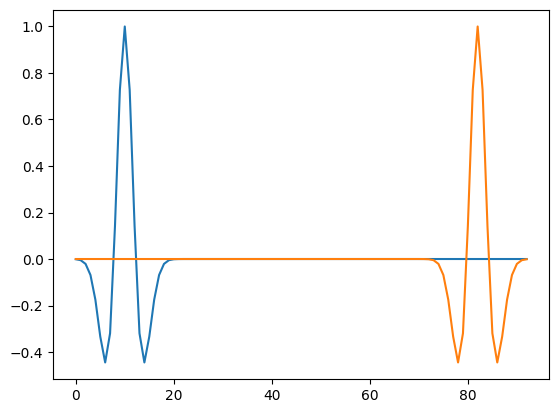

In [11]:
freq = 25
nt = 93
dt = 0.004
peak_time = 1.0 / freq

# source_amplitudes
source_amplitudes = (
    deepwave.wavelets.ricker(freq, nt, dt, peak_time).to(device)
)

source_amplitudes_inverse = torch.flip(source_amplitudes.cpu(),[0])

print(source_amplitudes.shape)
plt.plot(source_amplitudes.cpu())
plt.plot(source_amplitudes_inverse)
plt.show()

source_amplitudes_matrix = torch.zeros(nt,nt)
for index_i in range(nt):
    source_amplitudes_matrix[index_i,0:index_i+1] =  source_amplitudes_inverse[nt-index_i-1:nt]
    
#     plt.plot(source_amplitudes_matrix[index_i,:])
#     plt.show()

torch.Size([401, 401, 93])


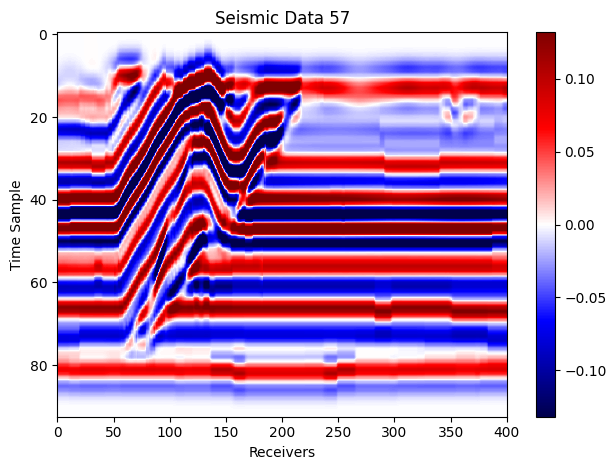

In [12]:
seismic_data = torch.matmul(reflectivity,source_amplitudes_matrix.T)
print(torch.matmul(reflectivity,source_amplitudes_matrix.T).shape)

shot_index = 50
vmin, vmax = torch.quantile(seismic_data[:,:,shot_index],
                            torch.tensor([0.01, 0.99]))
plt.imshow(seismic_data[1,:,:].cpu().T, aspect='auto',
             cmap=plt.cm.seismic, vmin=-vmax, vmax=vmax)
plt.xlabel("Receivers")
plt.ylabel("Time Sample")
plt.title("Seismic Data 57")
plt.colorbar()

plt.tight_layout()
# plt.savefig(result_path+'observed data.jpg')

spio.savemat(save_path + 'Overthrust3D_seismic_data.mat',{'seismic_data':seismic_data.cpu().data.numpy()})